In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fr-en-translator-t5/pytorch/default/1/training_metadata.pt


In [2]:
!pip install evaluate sacrebleu accelerate --no-deps

import torch
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from transformers import T5ForConditionalGeneration, T5Tokenizer, get_linear_schedule_with_warmup
from datasets import load_dataset
from tqdm import tqdm
import evaluate
import numpy as np
import re
import unicodedata
import os


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 7.9 MB/s eta 0:00:00


2025-05-12 19:27:54.488671: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747078074.663309      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747078074.713372      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Initialize device and enable mixed precision
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scaler = GradScaler()
print(f"Using device: {device}")

Using device: cuda


/tmp/ipykernel_31/1042247483.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [4]:
# Load model 
model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)
tokenizer = T5Tokenizer.from_pretrained("t5-small")

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [5]:
# Complete data loading cell with controlled sample display
import os
import torch
from tqdm import tqdm
from datasets import load_dataset
import re
import unicodedata
from transformers import T5Tokenizer

# Configuration
CACHE_FILE = "preprocessed_data.pt"
SAMPLE_SIZE = 3  # Number of samples to show
MAX_EXAMPLES = 50000  # Total examples to process
tokenizer = T5Tokenizer.from_pretrained("t5-small")

# Clean text without printing
def clean_text(text):
    if not isinstance(text, str):
        return "[EMPTY]"
    text = unicodedata.normalize("NFC", text)
    text = re.sub(r'[^\w\s\'.,!?¿¡\-:;%$€£¥©®@#&*()\[\]{}]', '', text, flags=re.UNICODE)
    return re.sub(r'\s+', ' ', text).strip() or "[EMPTY]"

# Preprocessing function
def preprocess(ex):
    src_text = clean_text(ex['translation']['fr_XX'])
    tgt_text = clean_text(ex['translation']['en_XX'])
    
    if src_text == "[EMPTY]" or tgt_text == "[EMPTY]":
        return None
    
    inputs = tokenizer(
        f"translate French to English: {src_text}",
        max_length=256,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    
    labels = tokenizer(
        tgt_text,
        max_length=128,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    labels.input_ids[labels.input_ids == tokenizer.pad_token_id] = -100
    
    return {
        "input_ids": inputs.input_ids.squeeze(),
        "labels": labels.input_ids.squeeze()
    }

if os.path.exists(CACHE_FILE):
    raw_examples = torch.load(CACHE_FILE)
    print(f" Loaded {len(raw_examples)} preprocessed examples")
    print("Sample preview (first 3 examples):")
    for i in range(min(SAMPLE_SIZE, len(raw_examples))):
        ex = raw_examples[i][0]['translation']
        print(f"\nSample {i+1}:")
        print(f"FR: {ex['fr_XX'][:100]}...")
        print(f"EN: {ex['en_XX'][:100]}...")
else:
    print(f"⏳ Preprocessing dataset (showing first {SAMPLE_SIZE} samples)...")
    streamed_dataset = load_dataset(
        "ccaligned_multilingual",
        language_code="fr_XX",
        type="sentences",
        streaming=True,
        trust_remote_code=True
    )
    
    raw_examples = []
    samples_shown = 0
    
    for ex in tqdm(streamed_dataset["train"], desc="Processing", total=MAX_EXAMPLES):
        if 'translation' in ex:
            # Show raw samples before processing
            if samples_shown < SAMPLE_SIZE:
                print(f"\nSample {samples_shown+1} (Before preprocessing):")
                print(f"Raw FR: {ex['translation']['fr_XX'][:100]}...")
                print(f"Raw EN: {ex['translation']['en_XX'][:100]}...")
            
            # Process the example
            processed = preprocess(ex)
            if processed:
                raw_examples.append((ex, processed))
                
                # Show cleaned samples after processing
                if samples_shown < SAMPLE_SIZE:
                    print("\nAfter preprocessing:")
                    print(f"Input IDs shape: {processed['input_ids'].shape}")
                    print(f"Labels shape: {processed['labels'].shape}")
                    samples_shown += 1
                
                if len(raw_examples) >= MAX_EXAMPLES:
                    break
    
    torch.save(raw_examples, CACHE_FILE)
    print(f"\n Saved {len(raw_examples)} preprocessed examples to cache")

print("\nData loading complete! Ready for training.")

⏳ Preprocessing dataset (showing first 3 samples)...


README.md:   0%|          | 0.00/13.7k [00:00<?, ?B/s]

ccaligned_multilingual.py:   0%|          | 0.00/8.04k [00:00<?, ?B/s]

Processing:   0%|          | 152/50000 [00:01<06:14, 133.03it/s]


Sample 1 (Before preprocessing):
Raw FR: Au nom D'Allah le Tout Miséricordieux, le Très Miséricordieux,...
Raw EN: In the Holy name of Allah, most gracious, most merciful...

After preprocessing:
Input IDs shape: torch.Size([256])
Labels shape: torch.Size([128])

Sample 2 (Before preprocessing):
Raw FR: Au nom d'Allah, le Tout Miséricordieux, le Très Miséricordieux...
Raw EN: In the name of Allah, Most Gracious, Most Merciful....

After preprocessing:
Input IDs shape: torch.Size([256])
Labels shape: torch.Size([128])

Sample 3 (Before preprocessing):
Raw FR: Le plus grand parmi vous sera votre serviteur. Quiconque s'élèvera sera abaissé, et quiconque s'abai...
Raw EN: The greatest among you must be your servant. Whoever exalts himself will be humbled; but whoever hum...

After preprocessing:
Input IDs shape: torch.Size([256])
Labels shape: torch.Size([128])


Processing: 100%|█████████▉| 49999/50000 [00:35<00:00, 1419.51it/s]



 Saved 50000 preprocessed examples to cache

Data loading complete! Ready for training.


In [6]:
train_size = int(0.9 * len(raw_examples))
train_dataset = [x[1] for x in raw_examples[:train_size]]
valid_dataset = [x[1] for x in raw_examples[train_size:]]
valid_raw = [x[0] for x in raw_examples[train_size:]]

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=64)

In [7]:
# Try these adjustments:
optimizer = AdamW(model.parameters(), lr=1e-4)  
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                          num_warmup_steps=1000,  
                                          num_training_steps=len(train_loader)*10)  # More epochs

In [8]:
# Complete fixed training loop
from torch.cuda.amp import GradScaler, autocast
import torch

# Initialize
scaler = GradScaler()
num_epochs = 15
best_metrics = {'loss': float('inf'), 'acc': 0.0}
accumulation_steps = 4

# Early Stopping Parameters
patience = 3  # Number of epochs to wait
patience_counter = 0  # Counter for tracking patience
best_val_loss = float('inf')  # Best validation loss seen so far

for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0
    epoch_correct = 0
    epoch_tokens = 0
    optimizer.zero_grad()
    
    progress_bar = tqdm(train_loader, 
                         desc=f"Epoch {epoch+1}/{num_epochs}",
                         bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}')
    
    for step, batch in enumerate(progress_bar):
        with autocast(dtype=torch.float16):
            outputs = model(input_ids=batch['input_ids'].to(device), labels=batch['labels'].to(device))
            loss = outputs.loss / accumulation_steps
            epoch_train_loss += loss.item() * accumulation_steps

            logits = outputs.logits.detach()
            preds = torch.argmax(logits, dim=-1)
            mask = batch['labels'] != -100
            correct = (preds[mask] == batch['labels'].to(device)[mask]).sum().item()
            epoch_correct += correct
            epoch_tokens += mask.sum().item()
        
        scaler.scale(loss).backward()
        
        if (step + 1) % accumulation_steps == 0 or (step + 1) == len(train_loader):
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()
            
            # Update progress bar
            avg_loss = epoch_train_loss / (step + 1)
            avg_acc = epoch_correct / epoch_tokens
            progress_bar.set_postfix({
                'loss': f"{avg_loss:.3f}",
                'acc': f"{avg_acc:.1%}",
                'lr': f"{scheduler.get_last_lr()[0]:.1e}",
                'gpu': f"{torch.cuda.memory_allocated()/1e9:.1f}GB"
            }, refresh=True)
    
    # Validation phase
    model.eval()
    val_loss = 0
    val_correct = 0
    val_tokens = 0
    
    with torch.no_grad():
        for batch in tqdm(valid_loader, desc="Validating", leave=False):
            outputs = model(input_ids=batch['input_ids'].to(device), labels=batch['labels'].to(device))
            val_loss += outputs.loss.item()
            
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)
            mask = batch['labels'] != -100
            val_correct += (preds[mask] == batch['labels'].to(device)[mask]).sum().item()
            val_tokens += mask.sum().item()
    
    # Calculate metrics
    train_loss = epoch_train_loss / len(train_loader)
    train_acc = epoch_correct / epoch_tokens
    val_loss /= len(valid_loader)
    val_acc = val_correct / val_tokens

    # Epoch Summary
    print(f"""
    \n{'='*70}
    Epoch {epoch+1} Summary
    {'-'*70}
    Training   | Loss: {train_loss:.4f} | Accuracy: {train_acc:.2%} | Tokens: {epoch_tokens:,}
    Validation | Loss: {val_loss:.4f} | Accuracy: {val_acc:.2%} | Tokens: {val_tokens:,}
    {'='*70}
    """)

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        model.save_pretrained("./t5-fr-en-translation-best")
        tokenizer.save_pretrained("./t5-fr-en-translation-best")
        
        torch.save({
            'epoch': epoch,
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'best_acc': val_acc,
            'best_loss': val_loss
        }, "./t5-fr-en-translation-best/training_metadata.pt")
        
        print(f" New best model saved (Loss: {val_loss:.4f})")
    else:
        patience_counter += 1
    
    # Early stopping condition
    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch+1} due to no improvement in validation loss.")
        break

/tmp/ipykernel_31/2630418639.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/15:   0%|                    | 0/704 [00:00<?, ?it/s]/tmp/ipykernel_31/2630418639.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=torch.float16):
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
Epoch 1/15: 100%|████████████████████| 704/704 [07:21<00:00,  1.59it/s, loss=3.820, acc=41.1%, lr=1.8e-05, gpu=0.9GB]



    
    Epoch 1 Summary
    ----------------------------------------------------------------------
    Training   | Loss: 3.8201 | Accuracy: 41.05% | Tokens: 516,380
    Validation | Loss: 1.8458 | Accuracy: 62.29% | Tokens: 53,132
    
 New best model saved (Loss: 1.8458)


Epoch 2/15:   0%|                    | 0/704 [00:00<?, ?it/s]/tmp/ipykernel_31/2630418639.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=torch.float16):
Epoch 2/15: 100%|████████████████████| 704/704 [07:29<00:00,  1.57it/s, loss=1.966, acc=60.8%, lr=3.5e-05, gpu=0.9GB]



    
    Epoch 2 Summary
    ----------------------------------------------------------------------
    Training   | Loss: 1.9663 | Accuracy: 60.79% | Tokens: 516,380
    Validation | Loss: 1.4248 | Accuracy: 69.93% | Tokens: 53,132
    
 New best model saved (Loss: 1.4248)


Epoch 3/15:   0%|                    | 0/704 [00:00<?, ?it/s]/tmp/ipykernel_31/2630418639.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=torch.float16):
Epoch 3/15: 100%|████████████████████| 704/704 [07:29<00:00,  1.57it/s, loss=1.676, acc=66.0%, lr=5.3e-05, gpu=0.9GB]



    
    Epoch 3 Summary
    ----------------------------------------------------------------------
    Training   | Loss: 1.6758 | Accuracy: 66.00% | Tokens: 516,380
    Validation | Loss: 1.2978 | Accuracy: 72.38% | Tokens: 53,132
    
 New best model saved (Loss: 1.2978)


Epoch 4/15:   0%|                    | 0/704 [00:00<?, ?it/s]/tmp/ipykernel_31/2630418639.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=torch.float16):
Epoch 4/15: 100%|████████████████████| 704/704 [07:29<00:00,  1.57it/s, loss=1.542, acc=68.5%, lr=7.0e-05, gpu=0.9GB]



    
    Epoch 4 Summary
    ----------------------------------------------------------------------
    Training   | Loss: 1.5425 | Accuracy: 68.52% | Tokens: 516,380
    Validation | Loss: 1.2135 | Accuracy: 74.05% | Tokens: 53,132
    
 New best model saved (Loss: 1.2135)


Epoch 5/15:   0%|                    | 0/704 [00:00<?, ?it/s]/tmp/ipykernel_31/2630418639.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=torch.float16):
Epoch 5/15: 100%|████████████████████| 704/704 [07:29<00:00,  1.56it/s, loss=1.447, acc=70.2%, lr=8.8e-05, gpu=0.9GB]



    
    Epoch 5 Summary
    ----------------------------------------------------------------------
    Training   | Loss: 1.4472 | Accuracy: 70.24% | Tokens: 516,380
    Validation | Loss: 1.1566 | Accuracy: 75.19% | Tokens: 53,132
    
 New best model saved (Loss: 1.1566)


Epoch 6/15:   0%|                    | 0/704 [00:00<?, ?it/s]/tmp/ipykernel_31/2630418639.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=torch.float16):
Epoch 6/15: 100%|████████████████████| 704/704 [07:29<00:00,  1.57it/s, loss=1.371, acc=71.6%, lr=9.9e-05, gpu=0.9GB]



    
    Epoch 6 Summary
    ----------------------------------------------------------------------
    Training   | Loss: 1.3714 | Accuracy: 71.62% | Tokens: 516,380
    Validation | Loss: 1.1104 | Accuracy: 76.23% | Tokens: 53,132
    
 New best model saved (Loss: 1.1104)


Epoch 7/15:   0%|                    | 0/704 [00:00<?, ?it/s]/tmp/ipykernel_31/2630418639.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=torch.float16):
Epoch 7/15: 100%|████████████████████| 704/704 [07:28<00:00,  1.57it/s, loss=1.308, acc=72.7%, lr=9.6e-05, gpu=0.9GB]



    
    Epoch 7 Summary
    ----------------------------------------------------------------------
    Training   | Loss: 1.3078 | Accuracy: 72.74% | Tokens: 516,380
    Validation | Loss: 1.0804 | Accuracy: 76.94% | Tokens: 53,132
    
 New best model saved (Loss: 1.0804)


Epoch 8/15:   0%|                    | 0/704 [00:00<?, ?it/s]/tmp/ipykernel_31/2630418639.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=torch.float16):
Epoch 8/15: 100%|████████████████████| 704/704 [07:29<00:00,  1.57it/s, loss=1.259, acc=73.6%, lr=9.3e-05, gpu=0.9GB]



    
    Epoch 8 Summary
    ----------------------------------------------------------------------
    Training   | Loss: 1.2586 | Accuracy: 73.59% | Tokens: 516,380
    Validation | Loss: 1.0531 | Accuracy: 77.40% | Tokens: 53,132
    
 New best model saved (Loss: 1.0531)


Epoch 9/15:   0%|                    | 0/704 [00:00<?, ?it/s]/tmp/ipykernel_31/2630418639.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=torch.float16):
Epoch 9/15: 100%|████████████████████| 704/704 [07:28<00:00,  1.57it/s, loss=1.219, acc=74.4%, lr=9.0e-05, gpu=0.9GB]



    
    Epoch 9 Summary
    ----------------------------------------------------------------------
    Training   | Loss: 1.2189 | Accuracy: 74.42% | Tokens: 516,380
    Validation | Loss: 1.0402 | Accuracy: 77.73% | Tokens: 53,132
    
 New best model saved (Loss: 1.0402)


Epoch 10/15:   0%|                    | 0/704 [00:00<?, ?it/s]/tmp/ipykernel_31/2630418639.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=torch.float16):
Epoch 10/15: 100%|████████████████████| 704/704 [07:28<00:00,  1.57it/s, loss=1.189, acc=74.9%, lr=8.7e-05, gpu=0.9GB]



    
    Epoch 10 Summary
    ----------------------------------------------------------------------
    Training   | Loss: 1.1891 | Accuracy: 74.88% | Tokens: 516,380
    Validation | Loss: 1.0231 | Accuracy: 78.07% | Tokens: 53,132
    
 New best model saved (Loss: 1.0231)


Epoch 11/15:   0%|                    | 0/704 [00:00<?, ?it/s]/tmp/ipykernel_31/2630418639.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=torch.float16):
Epoch 11/15: 100%|████████████████████| 704/704 [07:29<00:00,  1.57it/s, loss=1.156, acc=75.5%, lr=8.5e-05, gpu=0.9GB]



    
    Epoch 11 Summary
    ----------------------------------------------------------------------
    Training   | Loss: 1.1558 | Accuracy: 75.47% | Tokens: 516,380
    Validation | Loss: 1.0105 | Accuracy: 78.38% | Tokens: 53,132
    
 New best model saved (Loss: 1.0105)


Epoch 12/15:   0%|                    | 0/704 [00:00<?, ?it/s]/tmp/ipykernel_31/2630418639.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=torch.float16):
Epoch 12/15: 100%|████████████████████| 704/704 [07:29<00:00,  1.57it/s, loss=1.134, acc=75.8%, lr=8.2e-05, gpu=0.9GB]



    
    Epoch 12 Summary
    ----------------------------------------------------------------------
    Training   | Loss: 1.1337 | Accuracy: 75.80% | Tokens: 516,380
    Validation | Loss: 1.0029 | Accuracy: 78.55% | Tokens: 53,132
    
 New best model saved (Loss: 1.0029)


Epoch 13/15:   0%|                    | 0/704 [00:00<?, ?it/s]/tmp/ipykernel_31/2630418639.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=torch.float16):
Epoch 13/15: 100%|████████████████████| 704/704 [07:30<00:00,  1.56it/s, loss=1.108, acc=76.3%, lr=7.9e-05, gpu=0.9GB]



    
    Epoch 13 Summary
    ----------------------------------------------------------------------
    Training   | Loss: 1.1080 | Accuracy: 76.25% | Tokens: 516,380
    Validation | Loss: 0.9884 | Accuracy: 78.90% | Tokens: 53,132
    
 New best model saved (Loss: 0.9884)


Epoch 14/15:   0%|                    | 0/704 [00:00<?, ?it/s]/tmp/ipykernel_31/2630418639.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=torch.float16):
Epoch 14/15: 100%|████████████████████| 704/704 [07:30<00:00,  1.56it/s, loss=1.092, acc=76.6%, lr=7.6e-05, gpu=0.9GB]



    
    Epoch 14 Summary
    ----------------------------------------------------------------------
    Training   | Loss: 1.0915 | Accuracy: 76.59% | Tokens: 516,380
    Validation | Loss: 0.9856 | Accuracy: 78.94% | Tokens: 53,132
    
 New best model saved (Loss: 0.9856)


Epoch 15/15:   0%|                    | 0/704 [00:00<?, ?it/s]/tmp/ipykernel_31/2630418639.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=torch.float16):
Epoch 15/15: 100%|████████████████████| 704/704 [07:29<00:00,  1.57it/s, loss=1.073, acc=76.9%, lr=7.3e-05, gpu=0.9GB]



    
    Epoch 15 Summary
    ----------------------------------------------------------------------
    Training   | Loss: 1.0730 | Accuracy: 76.90% | Tokens: 516,380
    Validation | Loss: 0.9790 | Accuracy: 79.10% | Tokens: 53,132
    
 New best model saved (Loss: 0.9790)


In [9]:
# Load best model for evaluation
best_model_path = "t5-fr-en-translation-best"
print(f"\n{'='*50}")
print(f"Loading best model from: {best_model_path}")
model = T5ForConditionalGeneration.from_pretrained(best_model_path).to(device)
print(f"Model loaded successfully!")
print(f"{'='*50}\n")

# Enhanced evaluation with multiple metrics
print("\nEvaluating model performance...")
print(f"{'-'*50}")


Loading best model from: t5-fr-en-translation-best
Model loaded successfully!


Evaluating model performance...
--------------------------------------------------


In [10]:
!ls t5-fr-en-translation-best

added_tokens.json	model.safetensors	 tokenizer_config.json
config.json		special_tokens_map.json  training_metadata.pt
generation_config.json	spiece.model


Evaluating:   1%|          | 1/100 [00:00<00:47,  2.08it/s]


Sample 1:
FR: Nouvelle date!
True EN: New Date!
Pred EN: New date!
--------------------------------------------------------------------------------

Sample 2:
FR: Nous sommes fermés pour l'été.
True EN: We are closed for the summer.
Pred EN: We are closed for summer.
--------------------------------------------------------------------------------


Evaluating:   4%|▍         | 4/100 [00:01<00:22,  4.30it/s]


Sample 3:
FR: J'ai lu et accepté le Règlement Général sur la Protection des Données (RGPD).
True EN: I have read and accepted the General Data Protection Regulation (GDPR).
Pred EN: I have read and accepted the General Regulation on the Protection of Données (RGPD).
--------------------------------------------------------------------------------


Evaluating: 100%|██████████| 100/100 [00:13<00:00,  7.51it/s]


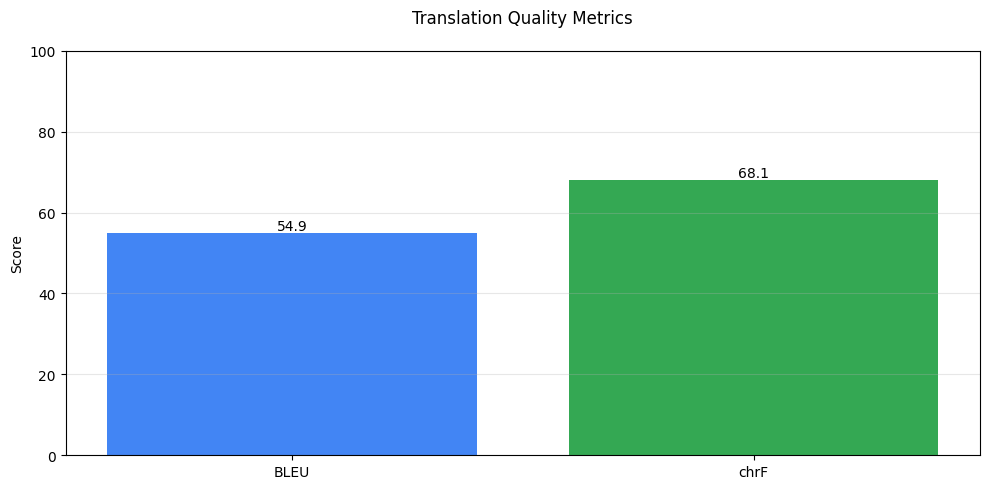


                            Final Evaluation Results                            
BLEU Score:         54.93
chrF Score:         68.12



In [11]:
# Updated evaluation function with proper BLEU/chrF calculation
import matplotlib.pyplot as plt

def evaluate_model(model, tokenizer, dataset, num_samples=100):
    # Install sacrebleu and portalocker if needed
    try:
        import sacrebleu
    except ImportError:
        !pip install sacrebleu portalocker --quiet
        import sacrebleu
    
    model.eval()
    samples = []
    predictions = []
    references = []
    
    with torch.no_grad():
        for i in tqdm(range(min(num_samples, len(dataset))), desc="Evaluating"):
            example = dataset[i]
            src_text = clean_text(example['translation']['fr_XX'])
            tgt_text = clean_text(example['translation']['en_XX'])
            
            input_ids = tokenizer(
                f"translate French to English: {src_text}", 
                return_tensors="pt"
            ).input_ids.to(device)
            
            outputs = model.generate(                input_ids,
                max_length=128,
                num_beams=4,
                early_stopping=True
            )
            pred = tokenizer.decode(outputs[0], skip_special_tokens=True)
            
            samples.append({
                "FR": src_text,
                "True EN": tgt_text,
                "Pred EN": pred
            })
            predictions.append(pred)
            references.append(tgt_text)  # Changed to simple list
            
            if i < 3:
                print(f"\nSample {i+1}:")
                print(f"FR: {src_text[:200]}{'...' if len(src_text) > 200 else ''}")
                print(f"True EN: {tgt_text[:200]}{'...' if len(tgt_text) > 200 else ''}")
                print(f"Pred EN: {pred[:200]}{'...' if len(pred) > 200 else ''}")
                print("-"*80)
    
    # Calculate metrics - FIXED FORMAT HERE
    bleu = sacrebleu.corpus_bleu(predictions, [references]).score  # Note [references] wrapped in list
    chrf = sacrebleu.corpus_chrf(predictions, [references]).score
    
    # Visualization
    plt.figure(figsize=(10, 5))
    metrics = ['BLEU', 'chrF']    
    scores = [bleu, chrf]
    colors = ['#4285F4', '#34A853']
    
    bars = plt.bar(metrics, scores, color=colors)
    plt.ylabel('Score')
    plt.title('Translation Quality Metrics', pad=20)
    plt.ylim(0, 100)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom')
    
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\n{'='*80}")
    print(f"{'Final Evaluation Results':^80}")
    print(f"{'='*80}")
    print(f"{'BLEU Score:':<20}{bleu:.2f}")
    print(f"{'chrF Score:':<20}{chrf:.2f}")
    print(f"{'='*80}\n")
    
    return samples, predictions, (bleu, chrf)

# Run evaluation
samples, preds, metrics = evaluate_model(model, tokenizer, valid_raw)

In [12]:
# Translation function (simplified)
def translate_text(model, tokenizer, text):
    # Preprocess the input text
    input_ids = tokenizer(f"translate French to English: {text}", return_tensors="pt").input_ids.to(device)
    
    # Generate translation output
    outputs = model.generate(input_ids, max_length=128, num_beams=4, early_stopping=True)
    translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    return translated_text

# Define the test cases
test_cases = {
    
    "Bonjour, comment allez-vous aujourd'hui?": "Hello, how are you today?",
    "Je m'appelle Pierre et j'habite à Paris.": "My name is Pierre and I live in Paris.",

    "La technologie transforme notre façon de vivre.": "Technology is transforming our way of life.",
    "L'ordinateur quantique représente une révolution informatique.": "The quantum computer represents a computing revolution.",

    "Veuillez trouver ci-joint mon curriculum vitae.": "Please find attached my resume.",
    "Nous vous remercions de votre fidélité.": "We thank you for your loyalty.",

    "Tu veux aller prendre un café demain matin?": "Do you want to go get coffee tomorrow morning?",
    "Ce film était vraiment génial!": "That movie was really great!",

    "Où se trouve la station de métro la plus proche?": "Where is the nearest metro station?",
    "Combien coûte ce sac à main?": "How much does this handbag cost?",

    "Je voudrais commander une tarte aux pommes.": "I would like to order an apple pie.",
    "L'addition, s'il vous plaît.": "The check, please.",

    "Quel est le prochain vol pour New York?": "What is the next flight to New York?",
    "Où puis-je trouver un taxi?": "Where can I find a taxi?",

    "Il va pleuvoir toute la journée demain.": "It will rain all day tomorrow.",
    "La température atteindra 30 degrés cet après-midi.": "The temperature will reach 30 degrees this afternoon.",

    "Avez-vous cette robe en taille 38?": "Do you have this dress in size 38?",
    "Je cherche un cadeau pour mon anniversaire de mariage.": "I'm looking for a gift for my wedding anniversary."

}

# Run the translations and compare results
for french_text, expected_translation in test_cases.items():
    print(f"French: {french_text}")
    translated_text = translate_text(model, tokenizer, french_text)
    print(f"Translated: {translated_text}")
    print(f"Expected: {expected_translation}")
    print(f"------------------------------------\n")

French: Bonjour, comment allez-vous aujourd'hui?
Translated: Hello, how will you be today?
Expected: Hello, how are you today?
------------------------------------

French: Je m'appelle Pierre et j'habite à Paris.
Translated: I call Pierre and live in Paris.
Expected: My name is Pierre and I live in Paris.
------------------------------------

French: La technologie transforme notre façon de vivre.
Translated: The technology transforms our way of life.
Expected: Technology is transforming our way of life.
------------------------------------

French: L'ordinateur quantique représente une révolution informatique.
Translated: Quantique ordinateur représente une révolution informatique.
Expected: The quantum computer represents a computing revolution.
------------------------------------

French: Veuillez trouver ci-joint mon curriculum vitae.
Translated: Please find this link in my curriculum.
Expected: Please find attached my resume.
------------------------------------

French: Nous vo

In [13]:
train_loss = [
    3.8201, 1.9663, 1.6758, 1.5425, 1.4472,
    1.3714, 1.3078, 1.2586, 1.2189, 1.1891,
    1.1558, 1.1337, 1.1080, 1.0915, 1.0730
]

val_loss = [
    1.8458, 1.4248, 1.2978, 1.2135, 1.1566,
    1.1104, 1.0804, 1.0531, 1.0402, 1.0231,
    1.0105, 1.0029, 0.9884, 0.9856, 0.9790
]

train_acc = [
    41.05, 60.79, 66.00, 68.52, 70.24,
    71.62, 72.74, 73.59, 74.42, 74.88,
    75.47, 75.80, 76.25, 76.59, 76.90
]

val_acc = [
    62.29, 69.93, 72.38, 74.05, 75.19,
    76.23, 76.94, 77.40, 77.73, 78.07,
    78.38, 78.55, 78.90, 78.94, 79.10
]


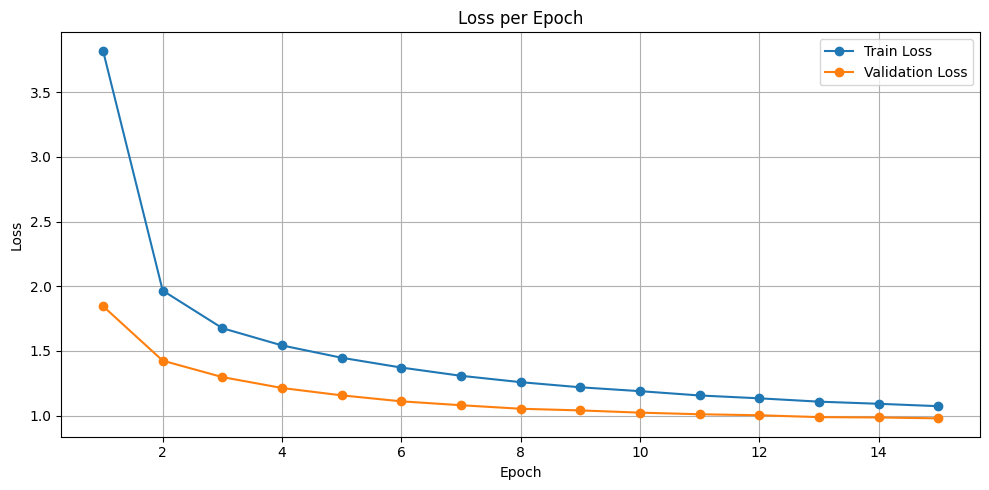

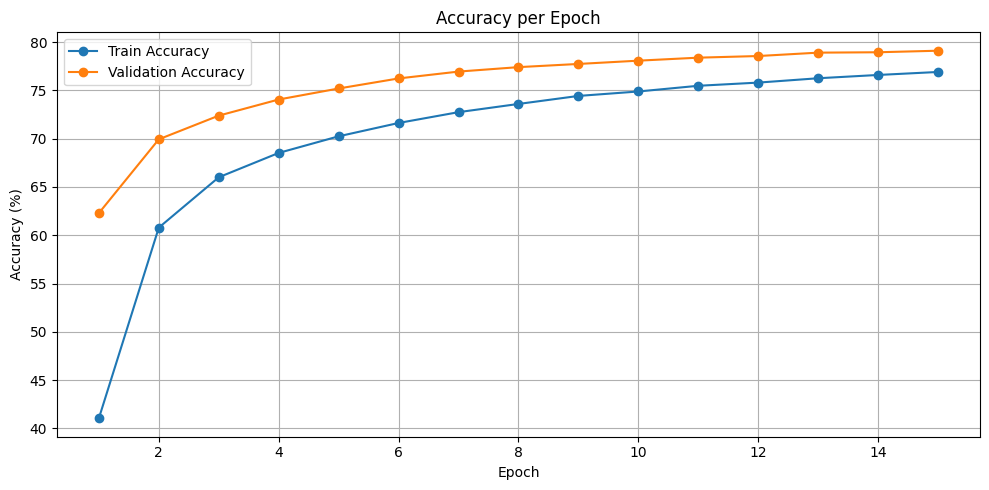

In [14]:
epochs = range(1, 16)

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('loss_plot.png')
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('accuracy_plot.png')
plt.show()
